<a href="https://colab.research.google.com/github/margaridaatedim/dlnn_waldo_group_2/blob/main/Binary_Classification_Wally_Final_Corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Where's Waldo

A project by Group #02:
* António Martins (20211369)
* Clara Barreto (20211768)
* Laryssa de Lucia (20211138)
* Lúcio Roque (20180830)
* Margarida Tedim (20201358)

##Data Acquisition

In [4]:
#Install Kaggle package 
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Import the file kaggle.json from your local machine 
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"clarabarreto","key":"4424ef9febe241938daeb017c7d4ec59"}'}

In [6]:
# Create the necessary directory for the Kaggle API
! mkdir  ~/.kaggle

# Move the kaggle.json file to this folder
! cp kaggle.json  ~/.kaggle/

# Set the permissions for the JSON file to 600
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Download kaggle dataset 
!kaggle datasets download -d residentmario/wheres-waldo

 98% 244M/248M [00:07<00:00, 32.8MB/s]
100% 248M/248M [00:08<00:00, 32.4MB/s]


In [8]:
# Unzip the Wheres-Wally dataset
! unzip wheres-waldo.zip

Streaming output truncated to the last 5000 lines.
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_2_6.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_2_7.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_2_8.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_2_9.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_0.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_1.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_10.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_11.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_12.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_13.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_14.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_15.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_2.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_3.jpg  
  inflating: wheres-waldo/Hey-Waldo/64/notwaldo/11_3_4.jpg  
  inflating: wheres-waldo/He

## Data Exploration 

In [9]:
# Import the needed packages

import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import pandas as pd
import numpy as np
from PIL import Image
import io
import os, glob
import random
import time


import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping

import os
import time
import random 
import zipfile
from shutil import copyfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

from sklearn.metrics import confusion_matrix
import keras
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

import os
import shutil
import random
import matplotlib.image as mpimg

Text(0.5, 1.0, '64-gray')

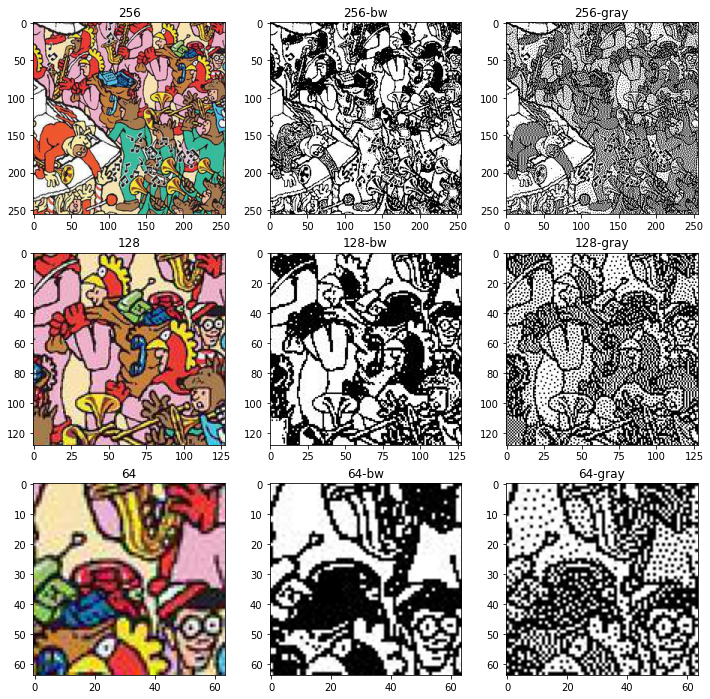

In [10]:
# Plot illustrating the same scene with Waldo at different levels of resolution: 256x256, 128x128, and 64x64: the dataset contains the same scenes at different levels of detail, or "close-up" views:

fig, axarr = plt.subplots(3, 3, figsize=(12, 12))

im = plt.imread("wheres-waldo/Hey-Waldo/256/waldo/10_3_1.jpg")
axarr[0][0].imshow(im)
axarr[0][0].set_title("256")

im = plt.imread("wheres-waldo/Hey-Waldo/256-bw/waldo/10_3_1.jpg")
axarr[0][1].imshow(im)
axarr[0][1].set_title("256-bw")

im = plt.imread("wheres-waldo/Hey-Waldo/256-gray/waldo/10_3_1.jpg")
axarr[0][2].imshow(im)
axarr[0][2].set_title("256-gray")

im = plt.imread("wheres-waldo/Hey-Waldo/128/waldo/10_7_2.jpg")
axarr[1][0].imshow(im)
axarr[1][0].set_title("128")

im = plt.imread("wheres-waldo/Hey-Waldo/128-bw/waldo/10_7_2.jpg")
axarr[1][1].imshow(im)
axarr[1][1].set_title("128-bw")

im = plt.imread("wheres-waldo/Hey-Waldo/128-gray/waldo/10_7_2.jpg")
axarr[1][2].imshow(im)
axarr[1][2].set_title("128-gray")

im = plt.imread("wheres-waldo/Hey-Waldo/64/waldo/10_15_4.jpg")
axarr[2][0].imshow(im)
axarr[2][0].set_title("64")

im = plt.imread("wheres-waldo/Hey-Waldo/64-bw/waldo/10_15_4.jpg")
axarr[2][1].imshow(im)
axarr[2][1].set_title("64-bw")

im = plt.imread("wheres-waldo/Hey-Waldo/64-gray/waldo/10_15_4.jpg")
axarr[2][2].imshow(im)
axarr[2][2].set_title("64-gray")

### Visualisation of the Classes Distribution 

In [11]:
# Analyze the distribution of the classes in each of the datasets

def count_files(ls_folders, lookat):
  
  main_ls = [] # empty list to store the results of each folder   
  ls = [] # empty list to store the results of each subfolder  
  wdir = lookat
  

  for folder in ls_folders:
    # Count Waldos
    pathwaldo = wdir + folder + "/" + 'waldo'
    # Start the count of files in 0 
    file_waldo_count = 0
    # Read the archives and folders in the given path 
    for root, dirs, files in os.walk(pathwaldo):
      # Add the number of archives in the folder to the count 
      file_waldo_count += len(files)
  
    # Count not Waldos
    pathnotwaldo = wdir + folder + "/" + 'notwaldo'
    # Start the count of files in 0 
    file_notwaldo_count = 0
    # Read the archives and folders in the given path 
    for root, dirs, files in os.walk(pathnotwaldo):
      # Add the number of archives in the folder to the count 
      file_notwaldo_count += len(files)

    # Save the individual informations in the folder  
    ls.append(folder)
    ls.append(file_waldo_count)
    ls.append(file_notwaldo_count)
    # Add the main list 
    main_ls.append(ls)
    ls = []
  return main_ls


In [12]:
# Execute previous defined function on the Waldo dataset
data = count_files(os.listdir("wheres-waldo/Hey-Waldo/"), "wheres-waldo/Hey-Waldo/")

In [13]:
# Create a dataframe using the list of the lists specifying the columns names 
df = pd.DataFrame(data, columns=["Image_Size", "Waldos", "NotWaldo"])
df['Total_Images'] = df['Waldos'] + df['NotWaldo']
df['pctg_mainclass'] = round(df['Waldos']/df['Total_Images'],2)
df.sort_values('Image_Size', ascending = True, inplace = True)
# Show the dataframe
print(df)

        Image_Size  Waldos  NotWaldo  Total_Images  pctg_mainclass
0              128      27      1317          1344            0.02
3           128-bw      27      1317          1344            0.02
7         128-gray      27      1317          1344            0.02
2              256      31       286           317            0.10
5           256-bw      31       286           317            0.10
9         256-gray      31       286           317            0.10
8               64      39      5337          5376            0.01
4            64-bw      38      5043          5081            0.01
6          64-gray      38      5338          5376            0.01
1  original-images       0         0             0             NaN


### Getting additional images of Waldo

In [14]:
# Delete all waldo images
dir = '/content/wheres-waldo/Hey-Waldo/128/waldo'
for file in os.scandir(dir):
    os.remove(file.path)

In [15]:
# Download extra waldo images from github
!wget --no-check-certificate \
    "https://github.com/margaridaatedim/dlnn_waldo_group_2/raw/main/waldo128merge.zip" \
    -O "/content/waldo128merge.zip"

--2023-01-08 14:55:30--  https://github.com/margaridaatedim/dlnn_waldo_group_2/raw/main/waldo128merge.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/margaridaatedim/dlnn_waldo_group_2/main/waldo128merge.zip [following]
--2023-01-08 14:55:31--  https://raw.githubusercontent.com/margaridaatedim/dlnn_waldo_group_2/main/waldo128merge.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3116389 (3.0M) [application/zip]
Saving to: ‘/content/waldo128merge.zip’

/content/waldo128me 100%[===================>]   2.97M  --.-KB/s    in 0.02s   

2023-01-08 14:55:31 (126 MB/s) - ‘/content/waldo128merge.z

In [16]:
zip_ref = zipfile.ZipFile('/content/waldo128merge.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /tmp folder
zip_ref.close()

In [17]:
dir = '/content/waldo128merge'
for file in os.scandir(dir):
    shutil.move(file.path, "/content/wheres-waldo/Hey-Waldo/128/waldo")

### Data Augmentation

In [18]:
# Data Augmentation: 4 transformations from the original Waldo images
datagen = ImageDataGenerator(rotation_range=40,
                             shear_range=40,
                             channel_shift_range=80,
                             horizontal_flip=True)

In [19]:
# Apply transformations and save each image to the output folder
folder = '/content/wheres-waldo/Hey-Waldo/128/waldo/'

#image_list = []
for j in os.listdir(folder):
  img = load_img(folder+j)  # this is a PIL image
  x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
  x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
  # the .flow() command below generates batches of randomly transformed images
  # and saves the results to the `preview/` directory
  i = 0
  for batch in datagen.flow(
      x, batch_size=1, 
      save_to_dir='/content/wheres-waldo/Hey-Waldo/128/waldo',
      save_prefix='new_waldo', 
      save_format='jpeg'):
    i += 1
    if i > 3:
        break  # otherwise the generator would loop indefinitely
  
  #image_list.append(x)

In [20]:
# Zip images for download
# !zip -r /content/wheres-waldo/Hey-Waldo/128/waldo.zip /content/wheres-waldo/Hey-Waldo/128/waldo

  adding: content/wheres-waldo/Hey-Waldo/128/waldo/ (stored 0%)
  adding: content/wheres-waldo/Hey-Waldo/128/waldo/new_waldo_0_6722.jpeg (deflated 2%)
  adding: content/wheres-waldo/Hey-Waldo/128/waldo/256_09.jpg (deflated 1%)
  adding: content/wheres-waldo/Hey-Waldo/128/waldo/new_waldo_0_8609.jpeg (deflated 2%)
  adding: content/wheres-waldo/Hey-Waldo/128/waldo/new_waldo_0_5288.jpeg (deflated 2%)
  adding: content/wheres-waldo/Hey-Waldo/128/waldo/new_waldo_0_2544.jpeg (deflated 2%)
  adding: content/wheres-waldo/Hey-Waldo/128/waldo/new_waldo_0_298.jpeg (deflated 2%)
  adding: content/wheres-waldo/Hey-Waldo/128/waldo/new_waldo_0_5644.jpeg (deflated 2%)
  adding: content/wheres-waldo/Hey-Waldo/128/waldo/new_waldo_0_4635.jpeg (deflated 2%)
  adding: content/wheres-waldo/Hey-Waldo/128/waldo/new_waldo_0_8494.jpeg (deflated 2%)
  adding: content/wheres-waldo/Hey-Waldo/128/waldo/new_waldo_0_6176.jpeg (deflated 3%)
  adding: content/wheres-waldo/Hey-Waldo/128/waldo/new_waldo_0_3901.jpeg (defl

In [ ]:
# Download the images for control purposes
# files.download('/content/wheres-waldo/Hey-Waldo/128/waldo.zip')

IndexError: ignored

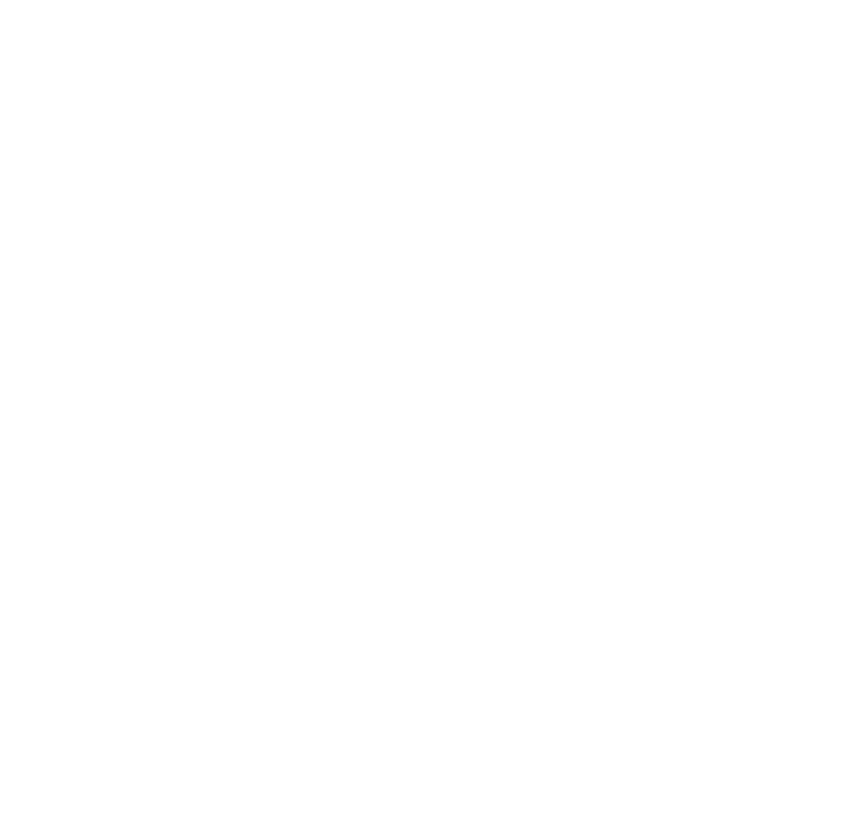

In [69]:
# Display the transformations applied by the data augmentation process

import random
from PIL import Image 

#newaldos_folder = '/content/sample_data/Waldo_test' #to change to 'wheres-waldo/Hey-Waldo/128/waldo/'
newaldos_folder = '/content/wheres-waldo/Hey-Waldo/128/waldo'

images = []
#for folder in os.listdir(nwaldos_folder):
for image in os.listdir(newaldos_folder + '/'):
  images.append(os.path.join(newaldos_folder, image))

plt.figure(1, figsize=(15, 15))
plt.axis('off')
n = 0
for i in range(16):
  n += 1
  random_img = random.choice(images)
  imgs = imread(random_img)
  plt.subplot(4, 4, n)
  #plt.axis('off')
  plt.imshow(imgs)

plt.show()

In [23]:
# Execute previous defined function on the Waldo dataset
data = count_files(os.listdir("wheres-waldo/Hey-Waldo/"), "wheres-waldo/Hey-Waldo/")

In [24]:
# Create a dataframe using the list of the lists specifying the columns names 
df = pd.DataFrame(data, columns=["Image_Size", "Waldos", "NotWaldo"])
df['Total_Images'] = df['Waldos'] + df['NotWaldo']
df['pctg_mainclass'] = round(df['Waldos']/df['Total_Images'],2)
df.sort_values('Image_Size', ascending = True, inplace = True)
# Show the dataframe
print(df)

        Image_Size  Waldos  NotWaldo  Total_Images  pctg_mainclass
0              128     632      1317          1949            0.32
3           128-bw      27      1317          1344            0.02
7         128-gray      27      1317          1344            0.02
2              256      31       286           317            0.10
5           256-bw      31       286           317            0.10
9         256-gray      31       286           317            0.10
8               64      39      5337          5376            0.01
4            64-bw      38      5043          5081            0.01
6          64-gray      38      5338          5376            0.01
1  original-images       0         0             0             NaN


## Data Preprocessing 

### Test and Train Split 

In [25]:
# Create a particular structure of directories

# Setting seed for ramdom
seed = 0
tf.keras.utils.set_random_seed(seed)

# List of class names [should be the same of subfolder - class name]
classes = ['notwaldo', 'waldo']

# List of datasets 
datasets = ['128', '64', '256']

# Set the percentage of files to move to train dataset
percentage = 0.8

# Loop through the datasets
for ds in datasets:
  # Loop through the classes
  for c in classes:
    # Set the source directory 
    src_dir = 'wheres-waldo/Hey-Waldo/' + ds + '/' + c

    # Set the base path for the new directories
    base_path = 'wheres-waldo/data/' + ds

    # Set the list of new directory names
    dir_names = ['training_data/' + c, 'testing_data/' + c]

    ## part 1: creating test and train directories 
    for dir_name in dir_names:
      # Create the full path for the new directory
      dir_path = os.path.join(base_path, dir_name)

      if os.path.isdir(dir_path):
        print("The directory " + dir_name + " already exists!")
      else:
        # Create the new directory, including any intermediate directories
        os.makedirs(dir_path)
        print("New directory created " + dir_name)

    ## part 2: moving files 

    # Get a list of all the files in the source directory
    files = os.listdir(src_dir)

    # Shuffle the list of files
    random.shuffle(files)

    # Calculate the number of files to move
    num_files = int(len(files) * percentage)

    # Move the first num_files files to the first destination directory
    for i in range(num_files):
      src_path = os.path.join(src_dir, files[i])
      dst_path = os.path.join(os.path.join(base_path, dir_names[0]), files[i])
      shutil.move(src_path, dst_path)

    # Move the remaining files to the second destination directory
    for i in range(num_files, len(files)):
      src_path = os.path.join(src_dir, files[i])
      dst_path = os.path.join(os.path.join(base_path, dir_names[1]), files[i])
      shutil.move(src_path, dst_path)

New directory created training_data/notwaldo
New directory created testing_data/notwaldo
New directory created training_data/waldo
New directory created testing_data/waldo
New directory created training_data/notwaldo
New directory created testing_data/notwaldo
New directory created training_data/waldo
New directory created testing_data/waldo
New directory created training_data/notwaldo
New directory created testing_data/notwaldo
New directory created training_data/waldo
New directory created testing_data/waldo


In [26]:
# Execute previous defined function considering new folder structure
data = count_files(os.listdir("wheres-waldo/data/128/"), "wheres-waldo/data/128/")

In [27]:
# Cria o dataframe a partir da lista de listas, especificando os nomes das colunas
df = pd.DataFrame(data, columns=["Image_Size", "Waldos", "NotWaldo"])
df['Total_Images'] = df['Waldos'] + df['NotWaldo']
df['pctg_mainclass'] = round(df['Waldos']/df['Total_Images'],2)
df.sort_values('Image_Size', ascending = True, inplace = True)
# Exibe o dataframe criado
print(df)

      Image_Size  Waldos  NotWaldo  Total_Images  pctg_mainclass
0   testing_data     127       264           391            0.32
1  training_data     505      1053          1558            0.32


### Visualization of a Sample of Images 



In [28]:
# Function to retrive a sample of images from the directories
def show_sample_images(folder_directory, class_):
    # Build a connection string
    full_path = folder_directory + class_ + "/"
    # Get a set of random images
    images = random.sample(os.listdir(full_path), 4)
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        img = mpimg.imread(full_path + img)
        ax = plt.subplot(2, 2,  i + 1)
        plt.imshow(img)
        plt.title("{} image of class \"{}\"".format(img.shape, class_))
        plt.axis("off")

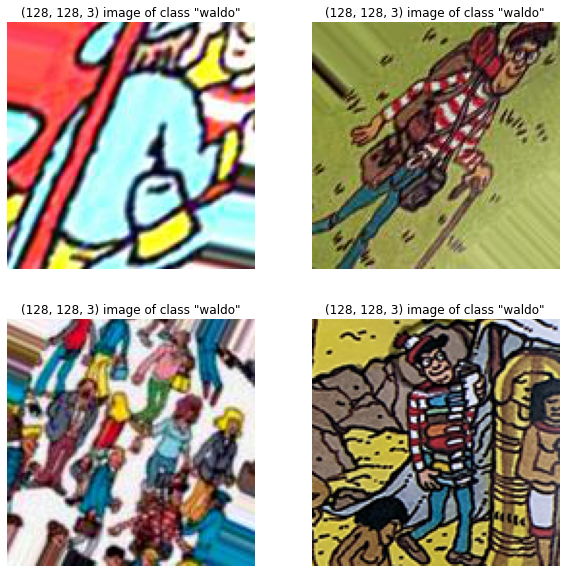

In [29]:
# Visualize a sample of "Waldo" images stored in the "training data" directory
show_sample_images("wheres-waldo/data/128/training_data/", "waldo")

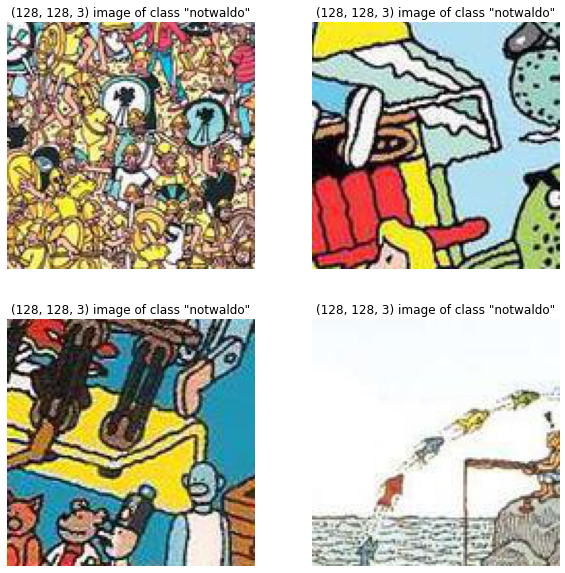

In [30]:
# Visualize a sample of "Not Waldo" images stored in the "training data" directory
show_sample_images("wheres-waldo/data/128/training_data/", "notwaldo")

### Creation of Tensors

In [31]:
## Tensor Configuration

tf.keras.utils.set_random_seed(seed)

# Image type parameters 
image_size=(128, 128)
color_mode='rgb'

# The number of images to include in each batch when training the model.
batch_size=128 # 64 128 256

# Split data for validation 
validation_split=0.2
shuffle=True

# Labels parameters 
labels = 'inferred'
label_mode="binary"
names = ['notwaldo', 'waldo']

# If resized keep the same width and height ratio as the original image
crop_to_aspect_ratio = True

#### Convert Image to Tensor

In [32]:
# Create training_folder and testing_folder variables to store the path of the directories
training_folder = 'wheres-waldo/data/128/training_data'
testing_folder = 'wheres-waldo/data/128/testing_data'

In [33]:
# Generate an object of type tf.data.Dataset for training dataset
ds_train = image_dataset_from_directory(training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='training',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)

Found 1558 files belonging to 2 classes.
Using 1247 files for training.


In [34]:
# Generate an object of type tf.data.Dataset for validation dataset
ds_val = image_dataset_from_directory(training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='validation',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)

Found 1558 files belonging to 2 classes.
Using 311 files for validation.


In [35]:
# Generate an object of type tf.data.Dataset for testing dataset
ds_test = image_dataset_from_directory(testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 391 files belonging to 2 classes.


#### Visualization of a Sample of Images from Tensors

In [36]:
# Function to retrive a batch of images from the Tensors
def show_sample_batch(ds, grid_size=(3, 3)):
    n_images = grid_size[0]*grid_size[1]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        ax = plt.subplot(grid_size[0], grid_size[1],  i + 1)
        plt.imshow(tf.cast(img, tf.int32))
        plt.title("{} image of class \"{}\"".format(img.shape, y), size=8)
        plt.axis("off")

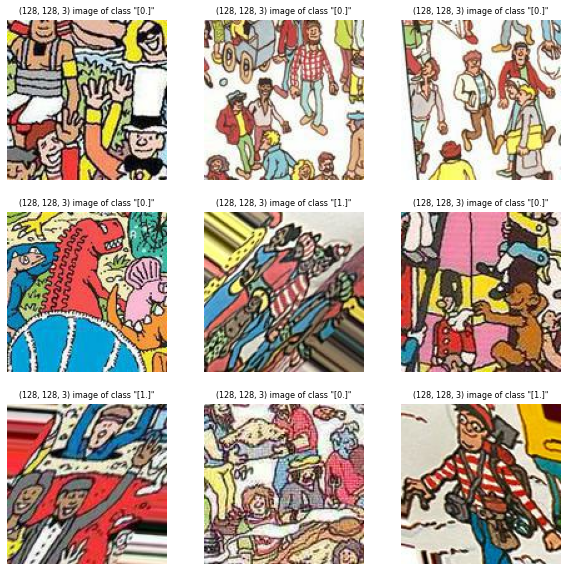

In [37]:
# Visualize a batch of images from Tensor "ds_train"
show_sample_batch(ds_train)

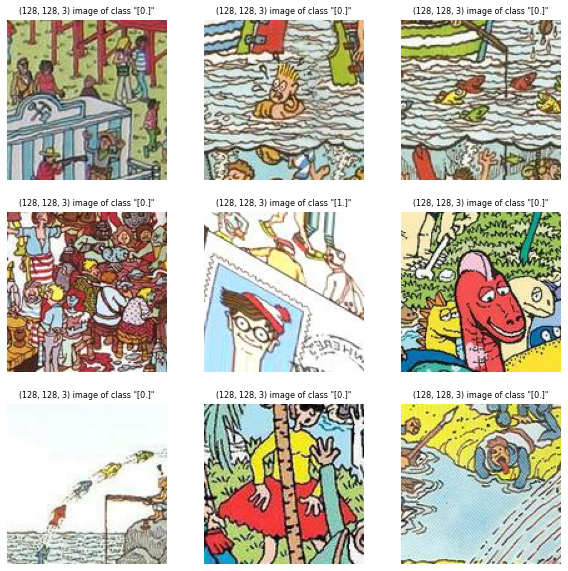

In [38]:
# Visualize a batch of images from Tensor "ds_val"
show_sample_batch(ds_val)

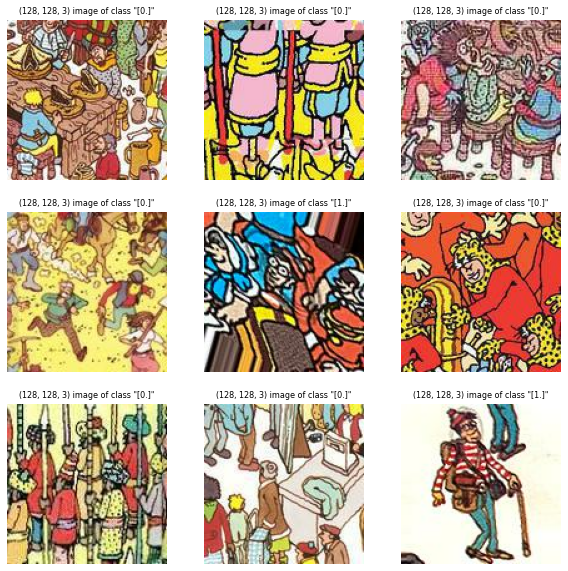

In [39]:
# Visualize a batch of images from Tensor "ds_test"
show_sample_batch(ds_test)

### Check tensor characteristics

In [40]:
# tbd

### Pixel Distribution 

In [41]:
# tbd

## Data Modeling

### Base models

In [42]:
# Create a batch from an instance of the tf.data.Dataset ds_train
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()

print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of y_train:", batch_y_train[0:5])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

(128, 128, 128, 3) (128, 1)

Sample of y_train: tf.Tensor(
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]], shape=(5, 1), dtype=float32)
Sample average of y_train: tf.Tensor(0.34375, shape=(), dtype=float32)


In [43]:
# Define Input Shape to be used in all the tested models
input_shape = batch_x_train.shape

In [44]:
# General parameters for LeNet architecture
kernel_size = (5, 5) # Why use these values
pool_size = (2, 2) # Why use these values

In [45]:
# Model with CNN architecture with 2 convolutional layers (desc); the following cnn models deviate from this one in only one defined aspect

tf.keras.utils.set_random_seed(seed)

cnn_basemodel_0 = Sequential([
                  layers.Rescaling(1.0 / 255),

                  layers.Conv2D(filters=16, kernel_size=kernel_size,
                                kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                  layers.Activation("relu"),
                  layers.MaxPooling2D(pool_size=pool_size),

                  layers.Conv2D(filters=16, kernel_size=kernel_size,
                                kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),

                  layers.Activation("relu"),
                  layers.MaxPooling2D(pool_size=pool_size),

                  layers.Flatten(),
                  
                  layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn_basemodel_0.build(input_shape)

cnn_basemodel_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (128, 128, 128, 3)        0         
                                                                 
 conv2d (Conv2D)             (128, 124, 124, 16)       1216      
                                                                 
 activation (Activation)     (128, 124, 124, 16)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (128, 62, 62, 16)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (128, 58, 58, 16)         6416      
                                                                 
 activation_1 (Activation)   (128, 58, 58, 16)         0         
                                                        

In [46]:
# Model with LeNet architecture similar to model _0 with 2 convolutional layers but with 32 filters each instead of 16

tf.keras.utils.set_random_seed(seed)

cnn_basemodel_1 = Sequential([
                   layers.Rescaling(1.0 / 255),
                              
                   layers.Conv2D(filters=32, kernel_size=kernel_size,
                                 kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                   layers.MaxPooling2D(pool_size=pool_size),

                   layers.Conv2D(filters=32, kernel_size=kernel_size,
                                 kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                   layers.MaxPooling2D(pool_size=pool_size),

                   layers.Flatten(),
                   
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn_basemodel_1.build(input_shape)

cnn_basemodel_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 conv2d_2 (Conv2D)           (128, 124, 124, 32)       2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (128, 62, 62, 32)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (128, 58, 58, 32)         25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (128, 29, 29, 32)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (128, 26912)             

In [47]:
# Model with LeNet architecture Similar to model _0 with 3 convolutional layers of 32 and 64 filters

tf.keras.utils.set_random_seed(seed)

cnn_basemodel_2 = Sequential([       
                   layers.Rescaling(1.0 / 255),
                               
                   layers.Conv2D(filters=32, kernel_size=kernel_size,
                                 kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                   layers.MaxPooling2D(pool_size=pool_size),

                   layers.Conv2D(filters=64, kernel_size=kernel_size,
                                 kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                   layers.MaxPooling2D(pool_size=pool_size),
                   
                   layers.Flatten(),

                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn_basemodel_2.build(input_shape)

cnn_basemodel_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 conv2d_4 (Conv2D)           (128, 124, 124, 32)       2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (128, 62, 62, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (128, 58, 58, 64)         51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (128, 29, 29, 64)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (128, 53824)             

In [48]:
# Model with LeNet architecture with 3 convolutional layers of 32
tf.keras.utils.set_random_seed(seed)

cnn_basemodel_3 = Sequential([
                   layers.Rescaling(1.0 / 255),
                   
                   layers.Conv2D(filters=32, kernel_size=kernel_size,
                                 kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                   layers.MaxPooling2D(pool_size=pool_size),

                   layers.Conv2D(filters=32, kernel_size=kernel_size,
                                 kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                   layers.MaxPooling2D(pool_size=pool_size),

                   layers.Conv2D(filters=32, kernel_size=kernel_size,
                                 kernel_initializer=initializers.GlorotNormal(seed=seed), activation='relu'),
                   layers.MaxPooling2D(pool_size=pool_size),

                   layers.Flatten(),

                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn_basemodel_3.build(input_shape)

cnn_basemodel_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 conv2d_6 (Conv2D)           (128, 124, 124, 32)       2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (128, 62, 62, 32)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (128, 58, 58, 32)         25632     
                                                                 
 max_pooling2d_7 (MaxPooling  (128, 29, 29, 32)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (128, 25, 25, 32)        

In [49]:
# General parameters for VGG architecture
kernel_size = (5, 5) # Why use these values
strides = (1, 1) # Why use these values
pool_size = (2, 2) # Why use these values
padding = 'same' # Why use these values

In [50]:
# Base model with VGG architecture with 3 convolutional layers (desc) to be similar to model _1
tf.keras.utils.set_random_seed(seed)

cnn_basemodel_4 = Sequential([
                    layers.Rescaling(1.0 / 255),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=128, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=64, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Flatten(),

                    layers.Dense(units=120, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

cnn_basemodel_4.build(input_shape)

cnn_basemodel_4.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 conv2d_9 (Conv2D)           (128, 128, 128, 256)      19456     
                                                                 
 max_pooling2d_9 (MaxPooling  (128, 64, 64, 256)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (128, 64, 64, 128)        819328    
                                                                 
 max_pooling2d_10 (MaxPoolin  (128, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (128, 32, 32, 64)        

In [51]:
# Base model with VGG architecture with 3 convolutional layers (asc) similar to base_model_4
tf.keras.utils.set_random_seed(seed)

cnn_basemodel_5 = Sequential([
                    layers.Rescaling(1.0 / 255),

                    layers.Conv2D(filters=64, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=128, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Flatten(),

                    layers.Dense(units=120, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

cnn_basemodel_5.build(input_shape)

cnn_basemodel_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 conv2d_12 (Conv2D)          (128, 128, 128, 64)       4864      
                                                                 
 max_pooling2d_12 (MaxPoolin  (128, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (128, 64, 64, 128)        204928    
                                                                 
 max_pooling2d_13 (MaxPoolin  (128, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (128, 32, 32, 256)       

In [52]:
# Base model with VGG architecture with 3 convolutional layers (asc) similar to model_5 with
# and additional dense layer and neurons 2048, 2048 and 2

tf.keras.utils.set_random_seed(seed)

cnn_basemodel_6 = Sequential([
                    layers.Rescaling(1.0 / 255),
    
                    layers.Conv2D(filters=64, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=128, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Flatten(),

                    layers.Dense(units=2048, activation='relu'),
                    layers.Dense(units=2048, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

cnn_basemodel_6.build(input_shape)

cnn_basemodel_6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 conv2d_15 (Conv2D)          (128, 128, 128, 64)       4864      
                                                                 
 max_pooling2d_15 (MaxPoolin  (128, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (128, 64, 64, 128)        204928    
                                                                 
 max_pooling2d_16 (MaxPoolin  (128, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (128, 32, 32, 256)       

In [53]:
# Base model with VGG architecture Similar to model _6 with an additional convolutional layer with
# same filters as previous layer and dense layers with double the neurons (4096, 4096 and 2)
tf.keras.utils.set_random_seed(seed)

cnn_basemodel_7 = Sequential([
                    layers.Rescaling(1.0 / 255),
                    
                    layers.Conv2D(filters=64, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=128, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Conv2D(filters=256, kernel_size=kernel_size,
                                  strides=strides, activation='relu', padding=padding),
                    layers.MaxPooling2D(pool_size=pool_size),

                    layers.Flatten(),

                    layers.Dense(units=4096, activation='relu'),
                    layers.Dense(units=4096, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

cnn_basemodel_7.build(input_shape)

cnn_basemodel_7.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (128, 128, 128, 3)        0         
                                                                 
 conv2d_18 (Conv2D)          (128, 128, 128, 64)       4864      
                                                                 
 max_pooling2d_18 (MaxPoolin  (128, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (128, 64, 64, 128)        204928    
                                                                 
 max_pooling2d_19 (MaxPoolin  (128, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (128, 32, 32, 256)       

f1_score


https://neptune.ai/blog/keras-metrics

In [54]:
def recall_m(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [55]:
# Compile models
cnn_basemodel_0.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_basemodel_1.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_basemodel_2.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_basemodel_3.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_basemodel_4.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_basemodel_5.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_basemodel_6.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])
cnn_basemodel_7.compile(optimizer=optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[f1_score, metrics.Recall(), metrics.Precision(), 'accuracy'])

### Model training

In [56]:
# Common attributes
epochs = 100
patience = 10
early_stop = EarlyStopping(patience=patience, monitor='f1_score', mode='max', restore_best_weights=True)

In [57]:
# Model training - history_cnn_0
start = time.time()
history_cnn_0 = cnn_basemodel_0.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
10/10 [==============================] - 11s 154ms/step - loss: 0.6580 - f1_score: 0.1645 - recall: 0.1691 - precision: 0.3770 - accuracy: 0.6367 - val_loss: 0.5766 - val_f1_score: 0.0119 - val_recall: 0.0103 - val_precision: 1.0000 - val_accuracy: 0.6913
Epoch 2/100
10/10 [==============================] - 1s 74ms/step - loss: 0.5567 - f1_score: 0.1421 - recall: 0.2230 - precision: 0.9192 - accuracy: 0.7394 - val_loss: 0.5074 - val_f1_score: 0.2061 - val_recall: 0.3711 - val_precision: 0.9474 - val_accuracy: 0.7974
Epoch 3/100
10/10 [==============================] - 1s 74ms/step - loss: 0.4828 - f1_score: 0.3051 - recall: 0.4853 - precision: 0.8609 - accuracy: 0.8059 - val_loss: 0.4630 - val_f1_score: 0.2496 - val_recall: 0.4639 - val_precision: 0.9574 - val_accuracy: 0.8264
Epoch 4/100
10/10 [==============================] - 1s 74ms/step - loss: 0.4451 - f1_score: 0.3107 - recall: 0.5147 - precision: 0.8974 - accuracy: 0.8220 - val_loss: 0.4356 - val_f1_score: 0.3378 - 

In [58]:
# Model training - history_cnn_1
start = time.time()

history_cnn_1 = cnn_basemodel_1.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
10/10 [==============================] - 4s 198ms/step - loss: 0.7304 - f1_score: 0.2020 - recall_1: 0.2328 - precision_1: 0.4798 - accuracy: 0.6664 - val_loss: 0.6139 - val_f1_score: 0.0706 - val_recall_1: 0.0928 - val_precision_1: 1.0000 - val_accuracy: 0.7170
Epoch 2/100
10/10 [==============================] - 1s 99ms/step - loss: 0.5584 - f1_score: 0.1934 - recall_1: 0.2917 - precision_1: 0.8686 - accuracy: 0.7538 - val_loss: 0.5055 - val_f1_score: 0.3983 - val_recall_1: 0.5567 - val_precision_1: 0.7297 - val_accuracy: 0.7974
Epoch 3/100
10/10 [==============================] - 1s 96ms/step - loss: 0.4796 - f1_score: 0.3089 - recall_1: 0.4804 - precision_1: 0.8448 - accuracy: 0.8011 - val_loss: 0.5370 - val_f1_score: 0.5420 - val_recall_1: 0.6701 - val_precision_1: 0.5652 - val_accuracy: 0.7363
Epoch 4/100
10/10 [==============================] - 1s 97ms/step - loss: 0.4513 - f1_score: 0.3360 - recall_1: 0.5319 - precision_1: 0.8411 - accuracy: 0.8140 - val_loss: 0.410

In [59]:
# Model training - history_cnn_2
start = time.time()

history_cnn_2 = cnn_basemodel_2.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
10/10 [==============================] - 4s 197ms/step - loss: 0.8320 - f1_score: 0.2757 - recall_2: 0.2843 - precision_2: 0.3580 - accuracy: 0.5990 - val_loss: 0.5935 - val_f1_score: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_accuracy: 0.6881
Epoch 2/100
10/10 [==============================] - 2s 108ms/step - loss: 0.5640 - f1_score: 0.1956 - recall_2: 0.2549 - precision_2: 0.7273 - accuracy: 0.7249 - val_loss: 0.5189 - val_f1_score: 0.1955 - val_recall_2: 0.3402 - val_precision_2: 0.9706 - val_accuracy: 0.7910
Epoch 3/100
10/10 [==============================] - 2s 109ms/step - loss: 0.4875 - f1_score: 0.2836 - recall_2: 0.4436 - precision_2: 0.8578 - accuracy: 0.7939 - val_loss: 0.4514 - val_f1_score: 0.3445 - val_recall_2: 0.5670 - val_precision_2: 0.8594 - val_accuracy: 0.8360
Epoch 4/100
10/10 [==============================] - 2s 108ms/step - loss: 0.4531 - f1_score: 0.3460 - recall_2: 0.5319 - precision_2: 0.8189 - accuracy: 0.8083 - 

In [60]:
# Model training - history_cnn_3
start = time.time()

history_cnn_3 = cnn_basemodel_3.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
10/10 [==============================] - 3s 145ms/step - loss: 0.6244 - f1_score: 0.1045 - recall_3: 0.1029 - precision_3: 0.3559 - accuracy: 0.6455 - val_loss: 0.6018 - val_f1_score: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00 - val_accuracy: 0.6881
Epoch 2/100
10/10 [==============================] - 1s 100ms/step - loss: 0.5892 - f1_score: 0.1228 - recall_3: 0.1642 - precision_3: 0.7976 - accuracy: 0.7129 - val_loss: 0.5924 - val_f1_score: 0.5706 - val_recall_3: 0.6701 - val_precision_3: 0.5118 - val_accuracy: 0.6977
Epoch 3/100
10/10 [==============================] - 1s 102ms/step - loss: 0.5308 - f1_score: 0.2952 - recall_3: 0.4142 - precision_3: 0.7348 - accuracy: 0.7594 - val_loss: 0.4789 - val_f1_score: 0.2450 - val_recall_3: 0.4330 - val_precision_3: 0.9767 - val_accuracy: 0.8199
Epoch 4/100
10/10 [==============================] - 2s 107ms/step - loss: 0.4649 - f1_score: 0.3099 - recall_3: 0.4877 - precision_3: 0.8690 - accuracy: 0.8083 - 

In [61]:
# Model training - history_cnn_4
start = time.time()

history_cnn_4 = cnn_basemodel_4.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
10/10 [==============================] - 16s 1s/step - loss: 1.1243 - f1_score: 0.2000 - recall_4: 0.1814 - precision_4: 0.2891 - accuracy: 0.5862 - val_loss: 0.6175 - val_f1_score: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00 - val_accuracy: 0.6881
Epoch 2/100
10/10 [==============================] - 5s 423ms/step - loss: 0.6276 - f1_score: 0.0000e+00 - recall_4: 0.0000e+00 - precision_4: 0.0000e+00 - accuracy: 0.6728 - val_loss: 0.6045 - val_f1_score: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00 - val_accuracy: 0.6881
Epoch 3/100
10/10 [==============================] - 5s 413ms/step - loss: 0.6154 - f1_score: 0.0000e+00 - recall_4: 0.0000e+00 - precision_4: 0.0000e+00 - accuracy: 0.6728 - val_loss: 0.6336 - val_f1_score: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00 - val_accuracy: 0.6881
Epoch 4/100
10/10 [==============================] - 5s 414ms/step - loss: 0.6177 - f1_score: 0.0000e+00 - recall_4: 

In [62]:
# Model training - history_cnn_5
start = time.time()

history_cnn_5 = cnn_basemodel_5.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
10/10 [==============================] - 11s 648ms/step - loss: 1.5515 - f1_score: 0.2061 - recall_5: 0.1985 - precision_5: 0.3115 - accuracy: 0.5942 - val_loss: 0.5848 - val_f1_score: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00 - val_accuracy: 0.6881
Epoch 2/100
10/10 [==============================] - 3s 221ms/step - loss: 0.5470 - f1_score: 0.2501 - recall_5: 0.3309 - precision_5: 0.6683 - accuracy: 0.7273 - val_loss: 0.5105 - val_f1_score: 0.1482 - val_recall_5: 0.2371 - val_precision_5: 1.0000 - val_accuracy: 0.7621
Epoch 3/100
10/10 [==============================] - 3s 217ms/step - loss: 0.4835 - f1_score: 0.2467 - recall_5: 0.4020 - precision_5: 0.9061 - accuracy: 0.7907 - val_loss: 0.4159 - val_f1_score: 0.2593 - val_recall_5: 0.4845 - val_precision_5: 0.9792 - val_accuracy: 0.8360
Epoch 4/100
10/10 [==============================] - 3s 219ms/step - loss: 0.4427 - f1_score: 0.3212 - recall_5: 0.5221 - precision_5: 0.8875 - accuracy: 0.8220 -

In [63]:
# Model training - history_cnn_6
start = time.time()

history_cnn_6 = cnn_basemodel_6.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
10/10 [==============================] - 5s 403ms/step - loss: 5.7463 - f1_score: 0.3877 - recall_6: 0.3309 - precision_6: 0.2789 - accuracy: 0.5012 - val_loss: 0.6230 - val_f1_score: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_precision_6: 0.0000e+00 - val_accuracy: 0.6881
Epoch 2/100
10/10 [==============================] - 3s 258ms/step - loss: 0.6376 - f1_score: 0.0000e+00 - recall_6: 0.0000e+00 - precision_6: 0.0000e+00 - accuracy: 0.6728 - val_loss: 0.6100 - val_f1_score: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_precision_6: 0.0000e+00 - val_accuracy: 0.6881
Epoch 3/100
10/10 [==============================] - 3s 258ms/step - loss: 0.6218 - f1_score: 0.0000e+00 - recall_6: 0.0000e+00 - precision_6: 0.0000e+00 - accuracy: 0.6728 - val_loss: 0.6033 - val_f1_score: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_precision_6: 0.0000e+00 - val_accuracy: 0.6881
Epoch 4/100
10/10 [==============================] - 3s 259ms/step - loss: 0.5991 - f1_score: 0.0000e+00 - recall_6

In [64]:
# Model training - history_cnn_7
start = time.time()

history_cnn_7 = cnn_basemodel_7.fit(ds_train, epochs=epochs,
                                    validation_data=ds_val,
                                    callbacks=[early_stop])

print("Training time: {:.4f}s".format(time.time() - start))

Epoch 1/100
10/10 [==============================] - 8s 398ms/step - loss: 6.0829 - f1_score: 0.2000 - recall_7: 0.2059 - precision_7: 0.3281 - accuracy: 0.6022 - val_loss: 0.6206 - val_f1_score: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_precision_7: 0.0000e+00 - val_accuracy: 0.6881
Epoch 2/100
10/10 [==============================] - 3s 257ms/step - loss: 0.6299 - f1_score: 0.0000e+00 - recall_7: 0.0000e+00 - precision_7: 0.0000e+00 - accuracy: 0.6728 - val_loss: 0.6067 - val_f1_score: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_precision_7: 0.0000e+00 - val_accuracy: 0.6881
Epoch 3/100
10/10 [==============================] - 3s 258ms/step - loss: 0.6403 - f1_score: 0.0000e+00 - recall_7: 0.0000e+00 - precision_7: 0.0000e+00 - accuracy: 0.6728 - val_loss: 0.5957 - val_f1_score: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_precision_7: 0.0000e+00 - val_accuracy: 0.6881
Epoch 4/100
10/10 [==============================] - 3s 261ms/step - loss: 0.5920 - f1_score: 0.0000e+00 - recall_7

In [65]:
def hist_results_acc(history):

  # Create DataFrame object
  df_hist = pd.DataFrame.from_dict(history.history)
  df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

  # Plot learning curves
  secondary_y = ["f1_score", "val_f1_score"]  #  ["AUROC", "val_AUROC"] 
  ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                    secondary_y = secondary_y,
                    kind="line", figsize=(6, 3), grid=True, legend=True,
                    ylabel="Binary cross-entropy", 
                    xlabel="Epoch", title="Learning curves",                  
                    color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
  ax.right_ax.set_ylabel("Accuracy")
  ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
  ax.legend(loc=(0, -0.45), framealpha=1.0)
  plt.show()

In [66]:
# History and Models list

train_hist = [history_cnn_0, history_cnn_1, history_cnn_2, history_cnn_3, history_cnn_4, history_cnn_5, history_cnn_6, history_cnn_7]

models = ["cnn_basemodel_0", "cnn_basemodel_1", "cnn_basemodel_2", "cnn_basemodel_3", "cnn_basemodel_4", "cnn_basemodel_5", "cnn_basemodel_6", "cnn_basemodel_7"]

Model: cnn_basemodel_0


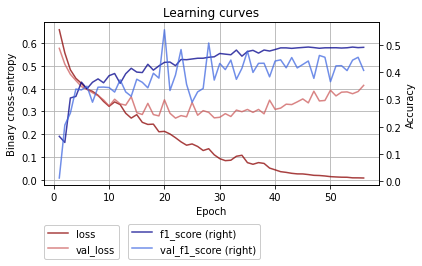

Model: cnn_basemodel_1


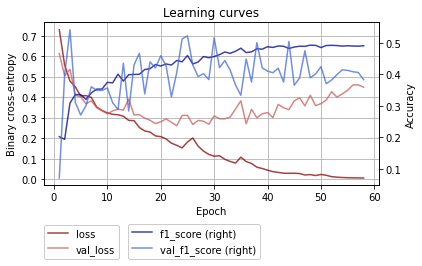

Model: cnn_basemodel_2


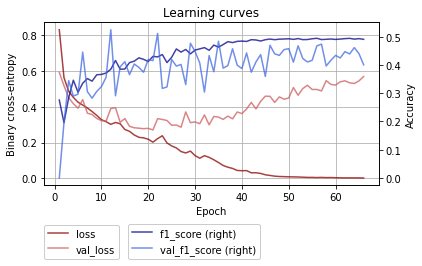

Model: cnn_basemodel_3


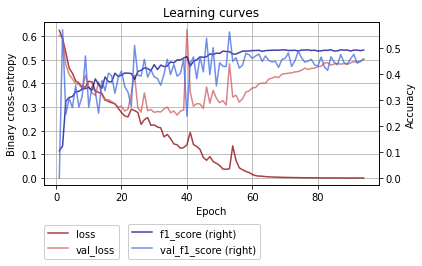

Model: cnn_basemodel_4


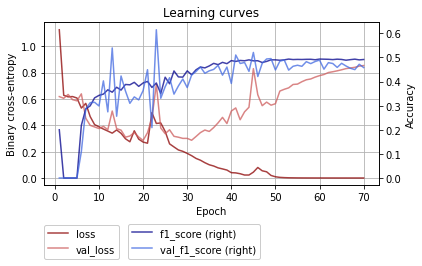

Model: cnn_basemodel_5


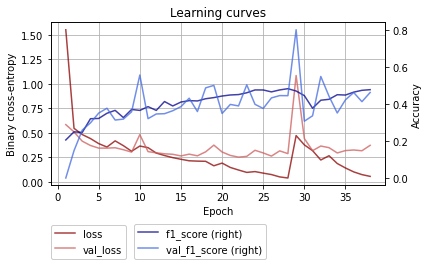

Model: cnn_basemodel_6


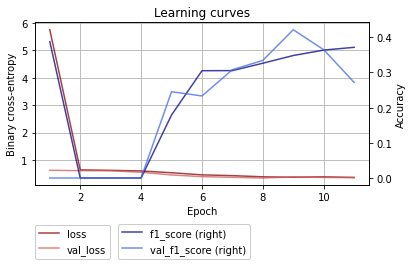

Model: cnn_basemodel_7


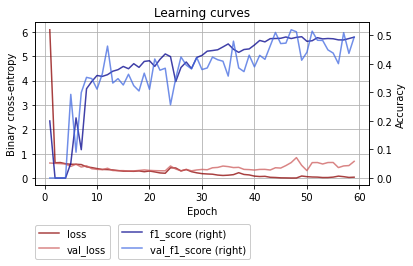

In [67]:
# Plot the learning curves -- CHANGE THIS PART = last year project

i = 0
for hist in train_hist:
  print("Model:", models[i])
  hist_results_acc(hist)
  plt.show()
  i= i + 1

### Model scores

In [68]:
# Model scores -- CHANGE THIS PART = last year project

i = 0
for hist in train_hist:
  highest_val_f1_score = max(hist.history['val_f1_score'])
  f1_score = max(hist.history['f1_score'])
  print("Model:", models[i], '->', 'val_f1_score =',highest_val_f1_score, ',', 'train_f1_score =',f1_score)
  i = i + 1

Model: cnn_basemodel_0 -> val_f1_score = 0.554942786693573 , train_f1_score = 0.491589218378067
Model: cnn_basemodel_1 -> val_f1_score = 0.5420190095901489 , train_f1_score = 0.49295753240585327
Model: cnn_basemodel_2 -> val_f1_score = 0.5244565606117249 , train_f1_score = 0.49424585700035095
Model: cnn_basemodel_3 -> val_f1_score = 0.5706204175949097 , train_f1_score = 0.4937252104282379
Model: cnn_basemodel_4 -> val_f1_score = 0.6148616671562195 , train_f1_score = 0.4932217597961426
Model: cnn_basemodel_5 -> val_f1_score = 0.8031526207923889 , train_f1_score = 0.4839007258415222
Model: cnn_basemodel_6 -> val_f1_score = 0.4214065968990326 , train_f1_score = 0.3877193033695221
Model: cnn_basemodel_7 -> val_f1_score = 0.5198879241943359 , train_f1_score = 0.4954499304294586


### Save the models

In [70]:
# Save the models

cnn_basemodel_0.save('cnn_basemodel_0.h5') # Justify why h5 for the report
cnn_basemodel_1.save('cnn_basemodel_1.h5')
cnn_basemodel_2.save('cnn_basemodel_2.h5')
cnn_basemodel_3.save('cnn_basemodel_3.h5')
cnn_basemodel_4.save('cnn_basemodel_4.h5')
cnn_basemodel_5.save('cnn_basemodel_5.h5')
cnn_basemodel_6.save('cnn_basemodel_6.h5')
cnn_basemodel_7.save('cnn_basemodel_7.h5')

https://www.tensorflow.org/guide/keras/save_and_serialize


WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 4 of 4). These functions will not be directly callable after loading.

### The chosen model - Hyper parameter tune

https://www.kaggle.com/code/theainerd/the-hitchiker-s-guide-to-cnn-with-fine-tuning


https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks


https://towardsdatascience.com/a-walkthrough-of-convolutional-neural-network-7f474f91d7bd


https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7

For the chosen model fine tune and compare with models with data augmentation and regularization

#### Batch Normalization

In [72]:
# Batch normalization - https://www.baeldung.com/cs/batch-normalization-cnn

# 1 model = Batch normalization - at the beginning of the model
# 1 model = Batch normalization - at the beginning of the model and at the start of each convolutional group

#### Activation

In [ ]:
# Activation ('relu') - batch + activation + maxpooling + conv2d

# 1 model = Activation - at the start of each convolutional group

#### Dropout

Usually, dropout is placed on the fully connected layers or dense layers only because they are the ones with the greater number of parameters and thus they’re likely to excessively co-adapting themselves causing overfitting.

https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7


Dropout is a preferable regularization technique to avoid overfitting in deep neural networks. The method simply drops out units in neural network according to the desired probability. A default value of 0.5 is a good choice to test with.

In [ ]:
# ONE MODEL WITH DROPOUT AFTER EACH THE MAXPOOLING LAYER
Conv_MaxPooling_DropOut.add(Dropout(0.3))

In [ ]:
# ONE MODEL WITH DROPOUT AFTER THE FIRST DENSE LAYER
Conv_MaxPooling_DropOut.add(Dropout(0.3))

In [ ]:
# ONE MODEL WITH DROPOUT AFTER EACH THE MAXPOOLING LAYER AND AFTER THE FIRST DENSE LAYER
Conv_MaxPooling_DropOut.add(Dropout(0.3))

#### Regularizer

In [ ]:
# REPLACE WITH CHOSEN MODEL ARCHITECTURE - https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7

l2_regularizer = Sequential()

l2_regularizer.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1),
                            activation='relu', padding='valid',kernel_regularizer=l2(0.01),
                            input_shape=(64, 64, 3)))
l2_regularizer.add(MaxPooling2D(pool_size=(2, 2)))

l2_regularizer.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1),
                            activation='relu', padding='valid',kernel_regularizer=l2(0.01)))
l2_regularizer.add(MaxPooling2D(pool_size=(2, 2)))

l2_regularizer.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1),
                            activation='relu', padding='valid',kernel_regularizer=l2(0.01)))
l2_regularizer.add(MaxPooling2D(pool_size=(2, 2)))

# MLP - input layer:
l2_regularizer.add(Flatten())
# MLP - hidden layer:
l2_regularizer.add(Dense(120, activation='relu',kernel_regularizer=l2(0.01)))

l2_regularizer.add(Dense(20, activation='softmax'))

# Check built model:
l2_regularizer.summary()

#### Regularizer + Dropout

In [ ]:
# REPLACE WITH CHOSEN MODEL ARCHITECTURE
l2_regularizer = Sequential()

l2_regularizer.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1),
                            activation='relu', padding='valid',kernel_regularizer=l2(0.01),
                            input_shape=(64, 64, 3)))
l2_regularizer.add(MaxPooling2D(pool_size=(2, 2)))
l2_regularizer.add(Dropout(0.3))

l2_regularizer.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1),
                            activation='relu', padding='valid',kernel_regularizer=l2(0.01)))
l2_regularizer.add(MaxPooling2D(pool_size=(2, 2)))
l2_regularizer.add(Dropout(0.3))

l2_regularizer.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1),
                            activation='relu', padding='valid',kernel_regularizer=l2(0.01)))
l2_regularizer.add(MaxPooling2D(pool_size=(2, 2)))
l2_regularizer.add(Dropout(0.3))

# MLP - input layer:
l2_regularizer.add(Flatten())
# MLP - hidden layer:
l2_regularizer.add(Dense(120, activation='relu',kernel_regularizer=l2(0.01)))
l2_regularizer.add(Dropout(0.3)) #0.2 0.3 0.5

l2_regularizer.add(Dense(20, activation='softmax'))

# Check built model:
l2_regularizer.summary()

#### Compile the fine tuned models

In [ ]:
# REPLACE THE NAMES AND MODELS

Conv_MaxPooling_Spatial.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics = ['acc'])
Conv_MaxPooling_DropOut.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics = ['acc'])
hidden_drop.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics = ['acc'])
hidden_conv_drop.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics = ['acc'])
l2_regularizer.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics = ['acc'])

#### Evaluate models

In [ ]:
# CHANGE THIS PART = LAST YEARS PROJECT
models=[chosen_model,Conv_MaxPooling_Spatial,Conv_MaxPooling_DropOut,
        hidden_drop,hidden_conv_drop,l2_regularizer]

for model in models:
    model.evaluate(test_generator, steps=8)

#### Train fine tuned models

#### Save models with fine tune

### Data Augmentation

In [ ]:
# Data augmentation

# Save outputs to folder for Waldo's and do this before the models

augmentation = Sequential([layers.RandomFlip(seed=seed), 
                           layers.RandomRotation(0.1, seed=seed), 
                           layers.RandomZoom(0.1, seed=seed),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="augmentation")

In [ ]:
# Visualize a single image that passess through the data augmentation pipeline

plt.imshow(tf.cast(augmentation(batch_x[0], training=True), tf.int32))

In [ ]:
# utility function to visualize how the data augmentation applies on a set of images

def show_sample_batch(ds, augmentation, grid_size=(3, 4), figsize=(14, 10)):
    n_images = grid_size[0]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(14, 10))
    count = 0
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        img_ = tf.cast(img, tf.int32)
        for j in range(grid_size[1]):
            # Prepare the image
            if j>0:
                img_ = tf.cast(augmentation(img_, training=True), tf.int32)
            ax = plt.subplot(grid_size[0], grid_size[1],  count + 1)        
            plt.imshow(img_)
            plt.title("{} {} image of class \"{}\"".format(
                img.shape, "original" if j==0 else "augmented", y), size=6)
            plt.axis("off")
            count+=1

show_sample_batch(ds_train, augmentation=augmentation)

In [ ]:
# ADAPT THIS CODE MOVING FORWARD

input_shape = tuple(batch_x_train.shape)
# Architecture v2
cnn3 = Sequential([# Add data augmentation
                   augmentation,
                   # The batch normalization layer 
                   layers.BatchNormalization(),                           
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=1, activation="sigmoid",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn3.build(input_shape)
# Check network
cnn3.summary()  # alternatively use tf.keras.utils.plot_model(cnn1, show_shapes=True)

In [ ]:
# 1.
cnn3.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])
# 2.
epochs = 10
history3 = cnn3.fit(ds_train, epochs=epochs, validation_data=ds_val)
# 3. 
df_hist3 = pd.DataFrame.from_dict(history3.history)
df_hist3["Epoch"] = np.arange(1, len(df_hist3) + 1, 1)
# 4.
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist3.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## Transfer Learning

#### Compiling the model


#### Training the model
[ver sessao training processos em Materia]

Displaying curves of loss and accuracy during training

#### Validate models - finetunning

After training the model, we evaluated its performance on the validation set and fine-tuned the model as needed to improve its performance.

#### Avoiding Overfitting

You already know about a number of techniques that can help mitigate overfitting, such as dropout
and weight decay (L2 regularization). We’re now going to work with a new one, specific to computer
vision and used almost universally when processing images with deep-learning models: data
augmentation.



##### Data augmentation

[pagina 104 slide 3 do professor]

Overfitting is caused by having too few samples to learn from, rendering you unable to train a
model that can generalize to new data. Given infinite data, your model would be exposed to every
possible aspect of the data distribution at hand: you would never overfit.

Data augmentation takes the approach of generating more training data from existing training

samples, by augmenting the samples via a number of random transformations that yield believable-
looking images.

The goal is that at training time, your model will never see the exact same picture twice. This helps
expose the model to more aspects of the data and generalize better.

##### Dropout layer

[pagina 106 slide 3 do professor]

If you train a new network using this data-augmentation configuration, the network will never see
the same input twice. But the inputs it sees are still heavily intercorrelated, because they come
from a small number of original images—you can’t produce new information, you can only remix
existing information.

As such, this may not be enough to completely get rid of overfitting. To further fight overfitting,
you’ll also add a Dropout layer to your model, right before the densely connected classifier.

##### Plotting the results (data augmentation + dropout)

### Retrain best model with all data

## Evaluate final performance

the model described is a very simple one, with just one layer of neurons and only one neuron in that layer. This neuron has one bias term, which is a value that is added to the input before it is processed by the neuron. The bias term helps the neuron make decisions about whether to transmit information or not.

The neuron in this model does not have an activation function, which is a special type of mathematical function that is used to determine whether the neuron should transmit information or not. Without an activation function, the neuron will always transmit its output, no matter what the input is.

Finally, the weights associated with this neuron are set to zero. Weights are values that are used to determine the importance of different inputs to the neuron. By setting the weights to zero, we are telling the neuron to ignore all of its inputs and just output a constant value.